In [20]:
# will autoupdate any of the packages imported:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import sys
sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
import pyclifford as pc

In [3]:
from numba import njit
import seaborn as sns
sns.set_theme()

In [3]:
def one_layer_brick_wall(circ,even=True):
    for ii in range(int(circ.N//2)):
        if even:
            circ.gate(2*ii,2*ii+1)
        else:
            circ.gate((2*ii+1),(2*ii+2)%circ.N)
    return circ

In [4]:
@njit
def generate_measurement_position(N,p):
    positions = []
    for i in range(N):
        if np.random.rand()<p:
            positions.append(i)
    return positions

In [5]:
def one_layer_measurement(circ,p):
    '''
    Input:
    p (float): measurement probability
    '''
    pos = generate_measurement_position(circ.N,p)
    circ.measure(*pos)
    return circ

In [6]:
def create_circuit(N,depth,p):
    circ = pc.circuit.Circuit(N)
    for i in range(depth):
        circ = one_layer_brick_wall(circ,even=True)
        circ = one_layer_measurement(circ,p)
        circ = one_layer_brick_wall(circ,even=False)
        circ = one_layer_measurement(circ,p)
    return circ

In [7]:
import time

In [9]:
ctime = time.time()
circ = create_circuit(300,10,0.1)
state = pc.zero_state(300)
state = circ.forward(state)
entropy = state.entropy([i for i in range(150)])
print(entropy)
print("time: ",time.time()-ctime)

3
time:  0.5204460620880127


# Average half-system entropy

When $p<p_c=0.16$, the system is in the entropy volume-law phase.

In [19]:
ps = np.array([0.1,0.13,0.15,0.17,0.2,0.23])

In [20]:
entropy_mean = np.zeros_like(ps)
entropy_std = np.zeros_like(ps)
for k in range(ps.shape[0]):
    print("measurement prob: ",ps[k])
    entropy_lst = []
    for _ in range(1000):
        circ = create_circuit(300,10,ps[k])
        state = pc.zero_state(300)
        state = circ.forward(state)
        entropy = state.entropy([i for i in range(150)])
        entropy_lst.append(entropy)
    entropy_mean[k] = np.mean(np.array(entropy_lst))
    entropy_std[k] = np.std(np.array(entropy_lst))/np.sqrt(1000)

measurement prob:  0.1
measurement prob:  0.13
measurement prob:  0.15
measurement prob:  0.17
measurement prob:  0.2
measurement prob:  0.23


Text(0.5, 1.0, '10 layers of brickwall circuit')

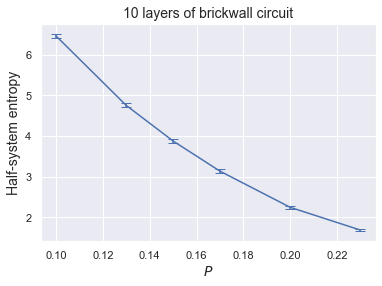

In [24]:
plt.errorbar(x = ps,y = entropy_mean,\
             yerr=entropy_std,capsize = 5)
plt.xlabel(r'$P$',fontsize = 14)
plt.ylabel("Half-system entropy",fontsize = 14)
plt.title("10 layers of brickwall circuit",fontsize = 14)